# Enhanced Preprocessing for Ensemble Learning

This notebook extends the existing preprocessing to generate multiple feature types for ensemble learning.

In [1]:
import os
import uuid
from tqdm import tqdm
import random
from collections import defaultdict
import numpy as np
import librosa
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from modules.PostgresDBHandler import PostgresDBHandler
import warnings

In [2]:
# Configuration
base_dir = "./"
intermediate_dir = "ensemble_intermediate_results"
fixedLength = 128
dbParams = {
    "dbname": "mydatabase",
    "user": "myuser",
    "password": "mypassword",
    "host": "postgres_server",
    "port": "5432",
}

# Feature types to generate
FEATURE_TYPES = [
    'mel_spectrogram', 'mfcc', 'chromagram', 'spectral_contrast',
    'tonnetz', 'constant_q', 'cqt', 'stft', 'harmonic_percussive', 'onset_strength'
]

# Create directories for each feature type
for feature_type in FEATURE_TYPES:
    os.makedirs(os.path.join(intermediate_dir, feature_type), exist_ok=True)

In [3]:
# Initialize database and ensure feature types exist
db = PostgresDBHandler(**dbParams)
db.connect()

# Check if feature types exist, if not create them
existing_feature_types = [ft['name'] for ft in db.get_all_feature_types()]

FEATURE_SHAPES = {
    'mel_spectrogram': (64, 128),
    'mfcc': (8, 128),
    'chromagram': (8, 128),
    'spectral_contrast': (3, 128),
    'tonnetz': (6, 128),
    'constant_q': (42, 128),
    'cqt': (42, 128),
    'stft': (512, 128),
    'harmonic_percussive': (1025, 128),
    'onset_strength': (1, 128)
}

feature_type_params = {
    'mel_spectrogram': {'n_mels': 64, 'fmin': 0, 'fmax': None},
    'mfcc': {'n_mfcc': 8, 'n_mels': 64},
    'chromagram': {'n_chroma': 8},
    'spectral_contrast': {'n_bands': 2},  # To get 3 bands in output (n_bands+1)
    'tonnetz': {},
    'constant_q': {'bins_per_octave': 6, 'n_bins': 42},  # 7 octaves x 6 bins/octave
    'cqt': {'bins_per_octave': 12, 'n_bins': 84},  # 7 octaves x 12 bins/octave (standard musical scale)
    'stft': {'n_fft': 512, 'hop_length': 256},
    'harmonic_percussive': {'margin': 3.0, 'n_fft': 2048, 'hop_length': 1024},
    'onset_strength': {'hop_length': 128}
}



for feature_type, params in feature_type_params.items():
    if feature_type not in existing_feature_types:
        description = f"{feature_type.replace('_', ' ').title()} features"
        db.insert_feature_type(feature_type, description, params)
        print(f"Created feature type: {feature_type}")

db.close()

In [4]:
def pad_or_truncate(array, fixed_length):
    # If fixed_length is a tuple (e.g., (freq_bins, time_steps)), get the time_steps
    if isinstance(fixed_length, tuple):
        fixed_length = fixed_length[1]

    # Defensive check: if array has fewer than 2 dims, raise error
    if array.ndim < 2:
        raise ValueError("Input array must have at least 2 dimensions")

    current_length = array.shape[1]

    if current_length > fixed_length:
        return array[:, :fixed_length]
    elif current_length < fixed_length:
        pad_width = fixed_length - current_length
        return np.pad(array, ((0, 0), (0, pad_width)), mode="constant")
    else:
        return array

In [5]:
def augment_audio(audio_data, sr):
    """Apply audio augmentation techniques."""
    # Time-stretching
    stretched = librosa.effects.time_stretch(audio_data, rate=1.1)
    
    # Pitch-shifting
    pitched = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=2)
    
    # Adding noise
    noise = np.random.randn(len(audio_data))
    audio_data_noisy = audio_data + 0.005 * noise
    
    # Ensure all augmented data have the same dtype
    audio_data_noisy = audio_data_noisy.astype(np.float32)
    stretched = stretched.astype(np.float32)
    pitched = pitched.astype(np.float32)
    
    augmented_data = {
        "time_stretch": stretched,
        "pitch_shifting": pitched,
        "noise": audio_data_noisy,
    }
    
    return augmented_data

In [6]:
def extract_feature_in_chunks(audio_data, sr, chunk_size=5.0, hop_size=2.5):
    feature_outputs = defaultdict(list)
    total_length = len(audio_data)
    chunk_sample_length = int(chunk_size * sr)
    hop_sample_length = int(hop_size * sr)

    def process_chunk(start):
        end = start + chunk_sample_length
        if end > total_length:
            chunk = np.pad(audio_data[start:], (0, end - total_length))
        else:
            chunk = audio_data[start:end]

        if len(chunk) < 64 or np.max(np.abs(chunk)) < 1e-5:
            return None

        chunk_features = {}

        for feature_type, params in feature_type_params.items():
            try:
                local_params = dict(params)
                if 'n_fft' in local_params:
                    local_params['n_fft'] = min(local_params['n_fft'], len(chunk))

                if feature_type == 'mel_spectrogram':
                    S = librosa.feature.melspectrogram(y=chunk, sr=sr, **local_params)
                    feat = librosa.power_to_db(S, ref=np.max)

                elif feature_type == 'mfcc':
                    feat = librosa.feature.mfcc(y=chunk, sr=sr, **local_params)

                elif feature_type == 'chromagram':
                    feat = librosa.feature.chroma_stft(y=chunk, sr=sr, **local_params)

                elif feature_type == 'spectral_contrast':
                    feat = librosa.feature.spectral_contrast(y=chunk, sr=sr, **local_params)

                elif feature_type == 'tonnetz':
                    y_harmonic = librosa.effects.harmonic(chunk)
                    feat = librosa.feature.tonnetz(y=y_harmonic, sr=sr)

                elif feature_type == 'constant_q':
                    C = np.abs(librosa.cqt(y=chunk, sr=sr, **local_params))
                    feat = librosa.amplitude_to_db(C, ref=np.max)

                elif feature_type == 'cqt':
                    C = np.abs(librosa.cqt(y=chunk, sr=sr, **local_params))
                    feat = librosa.amplitude_to_db(C, ref=np.max)

                elif feature_type == 'stft':
                    S = np.abs(librosa.stft(y=chunk, **local_params))
                    feat = librosa.amplitude_to_db(S, ref=np.max)

                elif feature_type == 'harmonic_percussive':
                    D = librosa.stft(y=chunk, n_fft=local_params.get('n_fft', 2048), hop_length=local_params.get('hop_length', 1024))
                    H, P = librosa.decompose.hpss(D)
                    H_db = librosa.amplitude_to_db(np.abs(H), ref=np.max)
                    P_db = librosa.amplitude_to_db(np.abs(P), ref=np.max)
                    feat = np.vstack([H_db, P_db])

                elif feature_type == 'onset_strength':
                    onset_env = librosa.onset.onset_strength(y=chunk, sr=sr, **local_params)
                    feat = onset_env[np.newaxis, :]

                else:
                    continue

                chunk_features[feature_type] = feat

            except Exception as e:
                print(f"[WARN] Feature extraction failed for {feature_type} on chunk starting at {start}: {e}")
                continue

        return chunk_features

    # Parallel chunk processing
    chunk_results = Parallel(n_jobs=-1)(
        delayed(process_chunk)(start)
        for start in range(0, total_length, hop_sample_length)
    )

    for chunk_result in chunk_results:
        if chunk_result is None:
            continue
        for feature_type, feat in chunk_result.items():
            feature_outputs[feature_type].append(feat)

    processed_features = {}
    for feature_name, chunks in feature_outputs.items():
        if not chunks:
            continue
        feat = np.concatenate(chunks, axis=1)
        target_shape = FEATURE_SHAPES[feature_name]
        feat = pad_or_truncate(feat, target_shape)
        processed_features[feature_name] = feat

    return processed_features


In [7]:
def process_file_ensemble(audio_index, db_params):
    import traceback
    db = PostgresDBHandler(**db_params)
    db.connect()
    warnings.filterwarnings("ignore")
    try:
        db_data = db.get_audio_file(audio_index)
        audio_path = db_data['filePath']
        sr = db_data["sampleRate"]

        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"Audio file not found: {audio_path}")

        y, _ = librosa.load(audio_path, sr=None)

        if y is None or len(y) == 0:
            raise ValueError(f"Empty audio data: {audio_path}")

        feature_type_ids = {ftype: db.get_feature_type_id(ftype) for ftype in FEATURE_TYPES}
        features = extract_feature_in_chunks(y, sr)

        for feature_type, data in features.items():
            unique_id = uuid.uuid4()
            feature_path = os.path.join(intermediate_dir, feature_type, f"{unique_id}_{feature_type}.npy")
            os.makedirs(os.path.dirname(feature_path), exist_ok=True)
            np.save(feature_path, data)

            db.insert_processed_audio(
                db_data["instrumentID"],
                db_data["audioID"],
                fixedLength,
                feature_type_ids[feature_type],
                feature_path,
                "original",
            )

        return True

    except Exception as e:
        print(f"Error processing audio {audio_index}: {e}")
        traceback.print_exc()
        return False
    finally:
        db.close()


In [8]:
def apply_ensemble_preprocessing(audios_ids, db_params, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_file_ensemble)(audio_index, db_params) for audio_index in tqdm(audios_ids)
    )
    successful = sum(results)
    total = len(audios_ids)
    print(f"Successfully processed {successful}/{total} audio files")
    return results


In [9]:
# Get all audio IDs and process them
db = PostgresDBHandler(**dbParams)
db.connect()
audio_ids = db.get_all_audio_ids()
print(f"Found {len(audio_ids)} audio files to process")
db.close()

Found 270 audio files to process


In [10]:
apply_ensemble_preprocessing(audio_ids, dbParams)


100%|██████████| 270/270 [00:34<00:00,  7.73it/s]


Successfully processed 270/270 audio files


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [11]:
def visualize_features_comparison(audio_file_path, label=None, sr=22050):
    y, loaded_sr = librosa.load(audio_file_path, sr=sr)
    features = extract_feature_in_chunks(y, loaded_sr)  # Extract all features at once

    n_features = len(features)
    cols = 3
    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

    if label is not None:
        fig.suptitle(f"Sample Label: {label}", fontsize=16)

    for i, (feature_name, feature_data) in enumerate(features.items()):
        ax = axes[i]

        if feature_name in ['mel_spectrogram', 'constant_q', 'stft', 'harmonic_percussive']:
            librosa.display.specshow(feature_data, sr=loaded_sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title(f'{feature_name.replace("_", " ").title()}')
        elif feature_name == 'mfcc':
            librosa.display.specshow(feature_data, x_axis='time', ax=ax)
            ax.set_title('MFCC')
        elif feature_name in ['chromagram', 'cqt']:
            librosa.display.specshow(feature_data, x_axis='time', y_axis='chroma', ax=ax)
            ax.set_title(f'{feature_name.replace("_", " ").title()}')
        elif feature_name == 'spectral_contrast':
            librosa.display.specshow(feature_data, x_axis='time', ax=ax)
            ax.set_title('Spectral Contrast')
        elif feature_name == 'tonnetz':
            librosa.display.specshow(feature_data, x_axis='time', ax=ax)
            ax.set_title('Tonal Centroids')
        elif feature_name == 'onset_strength':
            ax.plot(feature_data[0])
            ax.set_title('Onset Strength')
            ax.set_ylabel('Strength')
            ax.set_xlabel('Time')

    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    if label:
        plt.suptitle(f"Instrument: {label}", fontsize=16, y=1.02)    

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()


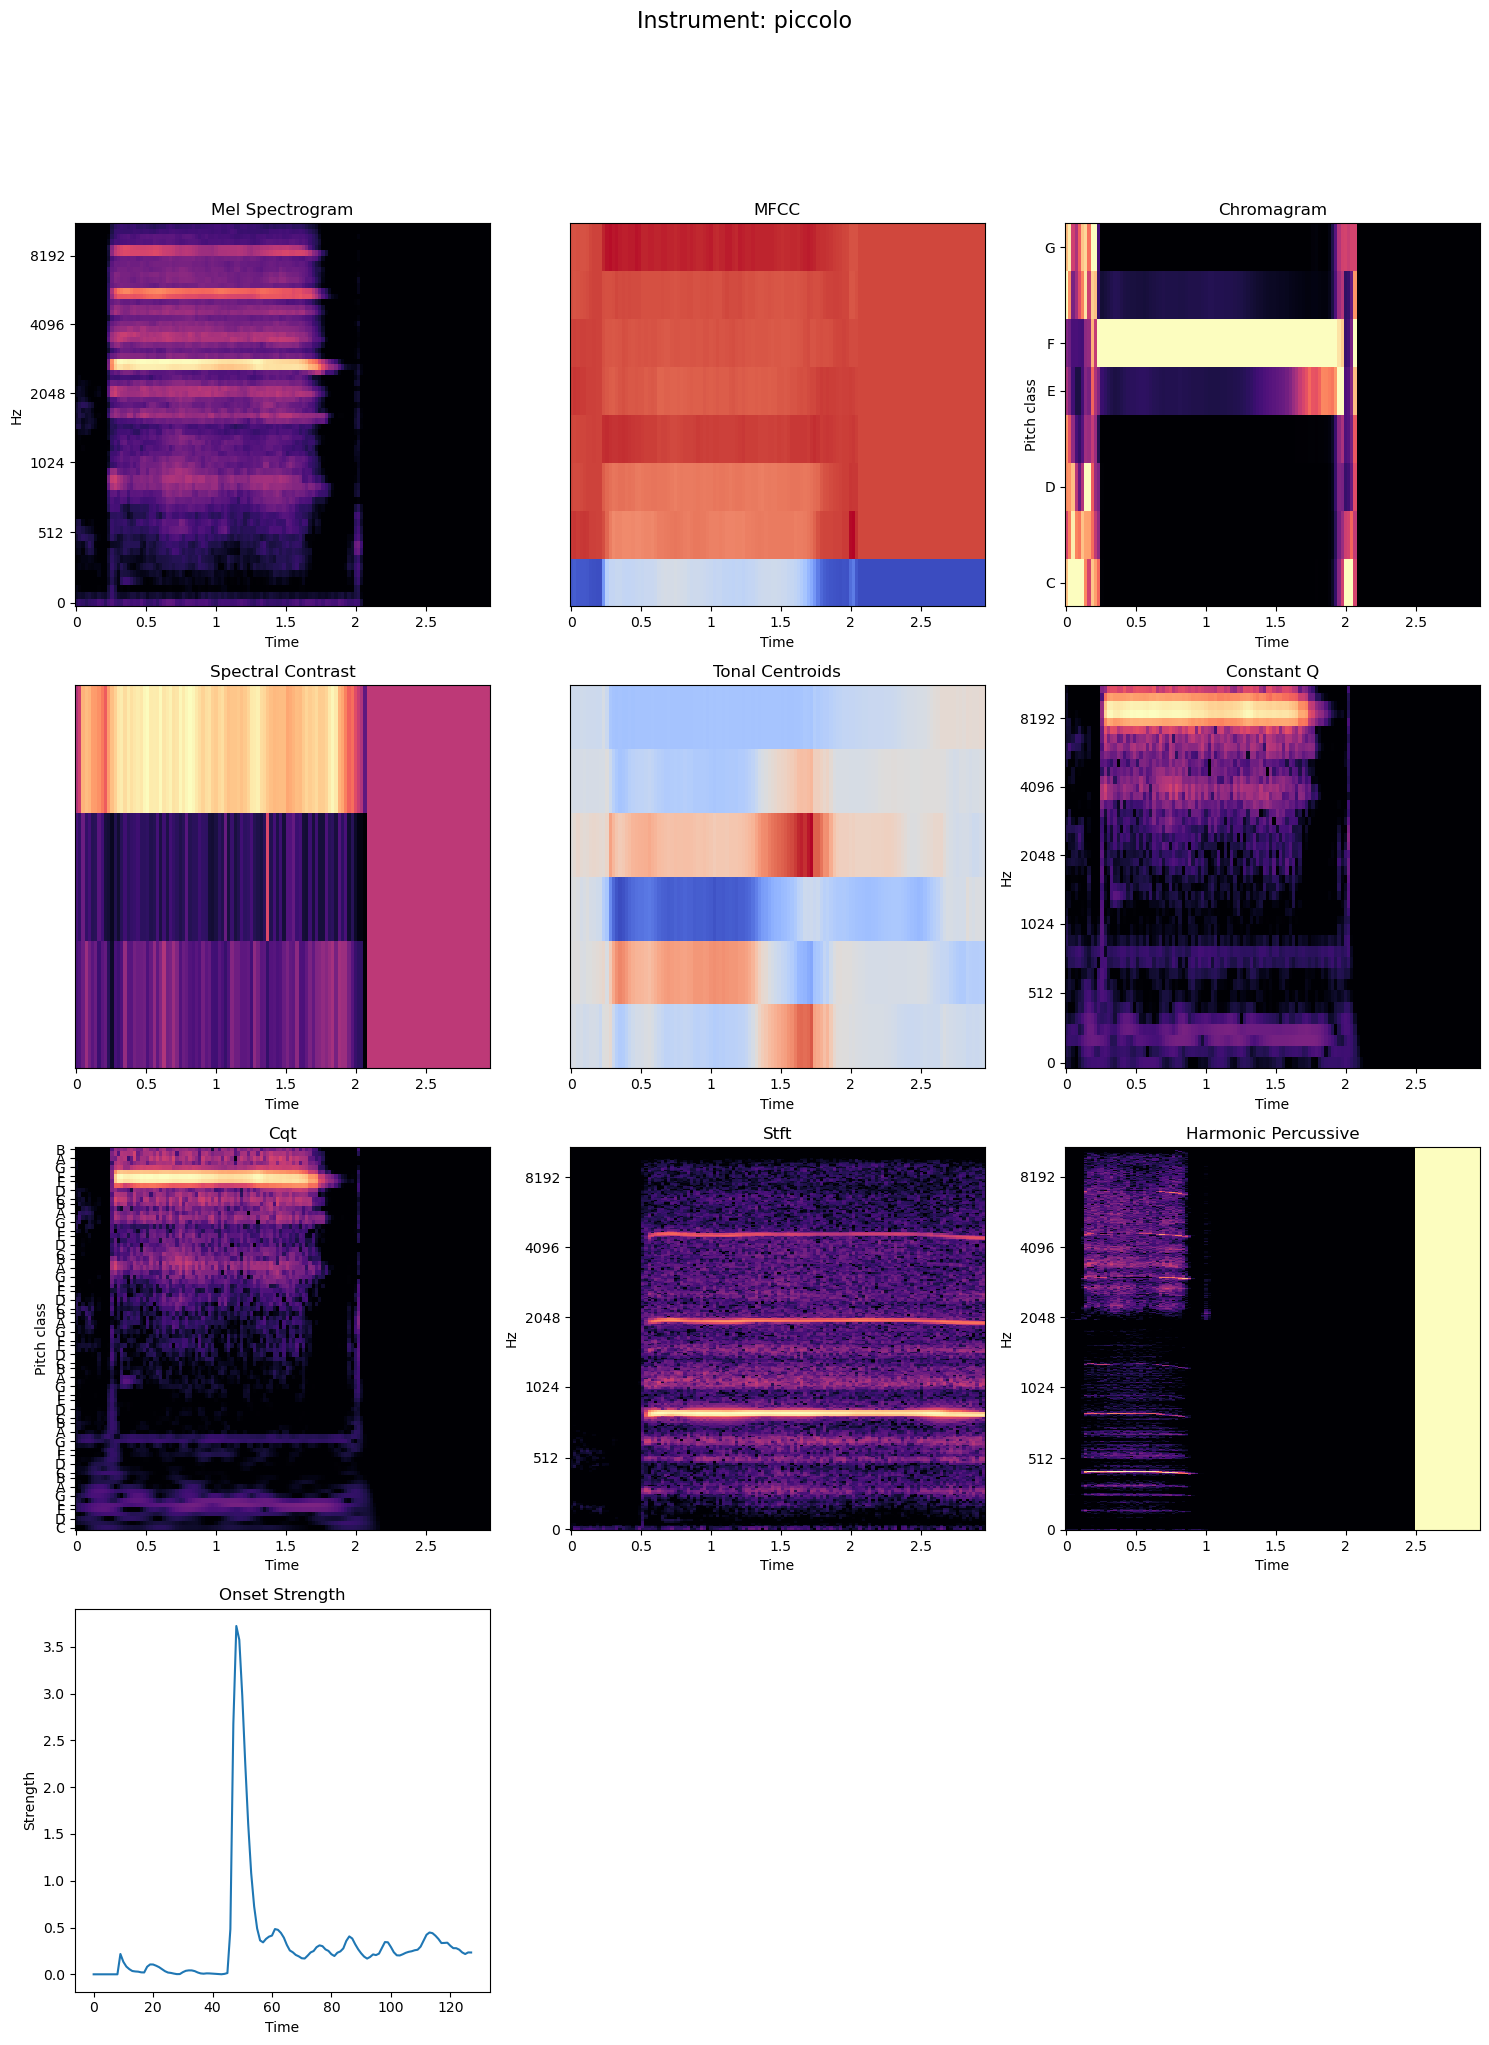

In [12]:
db = PostgresDBHandler(**dbParams)
db.connect()

# Get random audio ID and data
audio_ids = db.get_all_audio_ids()
random_audio_id = random.choice(audio_ids)
audio_data = db.get_audio_file(random_audio_id)
audio_path = audio_data["filePath"]

# Extract instrument label using existing execute_query + fetchone
instrument_id = audio_data["instrumentID"]
db.execute_query("SELECT name FROM Instruments WHERE instrumentID = %s", (instrument_id,))
instrument_name = db.fetchone()[0]

db.close()

# Pass label to visualization
visualize_features_comparison(audio_path, sr=22050, label=instrument_name)

In [13]:
# Statistics about processed data
def print_processing_stats():
    """Print statistics about the processed data."""
    db = PostgresDBHandler(**dbParams)
    db.connect()
    
    print("=== Processing Statistics ===")
    
    # Get counts for each feature type
    for feature_type in FEATURE_TYPES:
        processed_data = db.get_processed_data_by_feature_type(feature_type)
        print(f"{feature_type}: {len(processed_data)} samples")
    
    # Get augmentation statistics
    query = """
    SELECT augmentation, COUNT(*) as count 
    FROM Processed 
    GROUP BY augmentation
    """
    db.execute_query(query)
    augmentation_stats = db.fetchall()
    
    print("\n=== Augmentation Statistics ===")
    for aug, count in augmentation_stats:
        print(f"{aug}: {count} samples")
    
    db.close()

print_processing_stats()

=== Processing Statistics ===
mel_spectrogram: 270 samples
mfcc: 270 samples
chromagram: 270 samples
spectral_contrast: 270 samples
tonnetz: 270 samples
constant_q: 270 samples
cqt: 270 samples
stft: 270 samples
harmonic_percussive: 270 samples
onset_strength: 270 samples

=== Augmentation Statistics ===
original: 2700 samples
